In [51]:
%matplotlib inline
import pylab as plt
from astrometry.util.fits import *
from glob import glob
from astrometry.libkd.spherematch import match_radec, match_xy
from astrometry.util.util import * #anwcs, anwcs_create_cea_wcs
from scipy.ndimage.morphology import *
from scipy.ndimage.measurements import *
from scipy.interpolate import UnivariateSpline
import os

In [194]:
# Where to center the Hammer-Aitoff projection -- this value is required to keep the NGC and SGC
# each contained to a contiguous region.
rotate = 122.
W,H = 3600,1800
pixscale = 360. / W
ra,dec = rotate, 0.
zoom = 1.0
wcs = anwcs_create_hammer_aitoff(ra, dec, zoom, W, H, False)

In [195]:
S = fits_table('/global/project/projectdirs/cosmo/webapp/viewer-dev/data/sdss/plates-dr14.fits')
print(len(S), 'SDSS plates')
# Cut to unique RA,Dec
x,I = np.unique(np.vstack((S.racen, S.deccen)), axis=1, return_index=True)
S.cut(I)
print(len(S), 'unique RA,Dec')
I = match_radec(S.racen, S.deccen, S.racen, S.deccen, 5., notself=True, indexlist=True)
n = np.array([0 if i is None else len(i) for i in I])
I = np.flatnonzero(n > 10)
S.cut(I)
print(len(S), 'in large areas')

5888 SDSS plates
5198 unique RA,Dec
4985 in large areas


In [196]:
S.rax = S.racen - 360*(S.racen < (rotate+180))
S.decx = S.deccen
ok,x,y = wcs.radec2pixelxy(S.rax, S.decx)
sdssgrid = np.zeros((H,W), bool)
sdssgrid[(np.round(y)-1).astype(int), (np.round(x)-1).astype(int)] = True
# Plate radius = 1.5 degrees
#rpix = int(np.ceil(1.5 / pixscale))
rpix = 20
print('Plate radius', rpix)
dpix = 2*rpix+1
plate = np.zeros((dpix, dpix), bool)
plate[np.hypot((np.arange(dpix)-rpix)[:,np.newaxis], (np.arange(dpix)-rpix)[np.newaxis,:]) <= rpix] = True
grid2 = binary_dilation(sdssgrid, structure=plate)

Plate radius 20


In [197]:
def traverse_xy(x, y, r):
    I,J,D = match_xy(x, y, x, y, r, notself=True)
    matchlist = dict()
    for i,j,d in zip(I,J,D):
        if not i in matchlist:
            matchlist[i] = [j]
        else:
            matchlist[i].append(j)
    II = []
    inext = []
    # initialize with only "clockwise" matches to build a "fire break"
    iveto = set()
    cx = np.mean(x)
    cy = np.mean(y)
    t0 = np.arctan2(y[0]-cy, x[0]-cx)
    for j in matchlist[0]:
        if np.arctan2(y[j]-cy, x[j]-cx) < t0:
            II.append(j)
            continue
        inext.append(j)
    II.append(0)
    while len(inext):
        ii = inext.pop(0)
        if ii in II:
            continue
        II.append(ii)
        inext.extend(matchlist[ii])
    return II

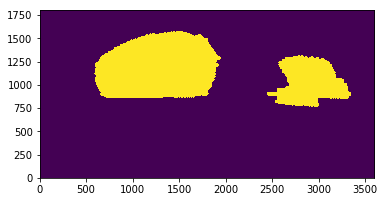

In [200]:
plt.imshow(grid2, origin='lower');

In [201]:
sdss_boundaries = []
blobs,nb = label(grid2)
for b in range(1,nb+1):
    thisblob = (blobs == b)
    boundary = np.logical_xor(binary_dilation(thisblob, iterations=1), thisblob)
    y,x = np.nonzero(boundary)
    I = traverse_xy(x, y, 5)
    xtr,ytr = x[I],y[I]
    xloop = np.append(xtr, xtr[:20])
    yloop = np.append(ytr, ytr[:20])
    nl = len(xloop)
    xr = np.arange(nl) / float(nl)
    splx = UnivariateSpline(xr, xloop, s=nl*15)
    sply = UnivariateSpline(xr, yloop, s=nl*15)
    sdss_boundaries.append((splx, sply))
    plt.show()    

In [202]:
annfn = '/global/project/projectdirs/cosmo/work/legacysurvey/dr8/ccds-annotated-decam-dr8.fits.gz'
tmpfn = '/tmp/ann-decam-dr8.fits'
cmd = 'gunzip -cd %s > %s' % (annfn, tmpfn)
os.system(cmd)

0

In [204]:
A1 = fits_table(tmpfn)
A2 = fits_table('/global/project/projectdirs/cosmo/work/legacysurvey/dr8/ccds-annotated-mosaic-dr8.fits.gz')
A3 = fits_table('/global/project/projectdirs/cosmo/work/legacysurvey/dr8/ccds-annotated-90prime-dr8.fits.gz')
len(A1),len(A2),len(A3)

(8277444, 241724, 144976)

In [205]:
AA = merge_tables((A1[A1.ccd_cuts == 0], A2[A2.ccd_cuts == 0], A3[A3.ccd_cuts == 0]))
AA.cut(AA.dec > -30)

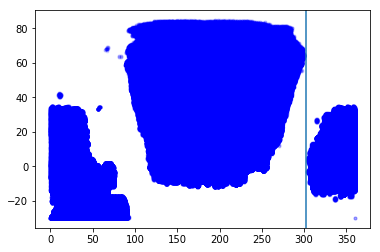

In [206]:
plt.plot(AA.ra, AA.dec, 'b.', alpha=0.1);
plt.axvline(302);

In [207]:
AA.rax = AA.ra + (AA.ra > (rotate+180))*-360

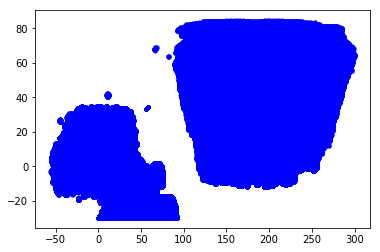

In [208]:
plt.plot(AA.rax, AA.dec, 'b.');

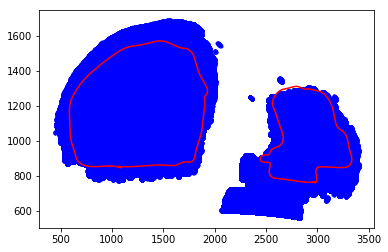

In [209]:
ok,x,y = wcs.radec2pixelxy(AA.rax, AA.dec)
plt.plot(x, y, 'b.')
for fx,fy in sdss_boundaries:
    tt = np.linspace(0, 1, 1000)
    plt.plot(fx(tt), fy(tt), 'r-')

In [210]:
ok,x,y = wcs.radec2pixelxy(AA.rax, AA.dec)
ccdmap = np.zeros((H,W), bool)
ix,iy = (x-0.5).astype(int), (y-0.5).astype(int)
ccdmap[iy,ix] = True
ccdmap = binary_dilation(ccdmap, structure=np.ones((5,5),bool))

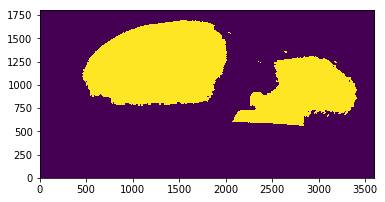

In [211]:
plt.imshow(ccdmap, origin='lower');

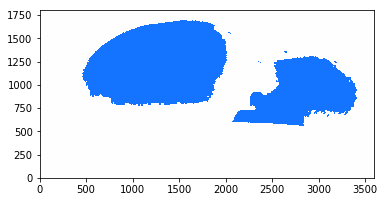

In [212]:
rgb = np.ones((H,W,4), np.uint8)
rgb[:,:,0][ccdmap] = 20
rgb[:,:,1][ccdmap] = 116 #113 #103
rgb[:,:,2][ccdmap] = 255 #249 #226
rgb[:,:,3][ccdmap] = 255
plt.imshow(rgb, origin='lower');

In [214]:
def draw_grid(wcs, ra_gridlines=None, dec_gridlines=None,
              ra_labels=None, dec_labels=None,
              ra_gridlines_decs=None, dec_gridlines_ras=None,
              ra_labels_dec=None, dec_labels_ra=None):
    if ra_gridlines_decs is None:
        ra_gridlines_decs = dec_gridlines
    if dec_gridlines_ras is None:
        ra_gridlines_decs = ra_gridlines
    ax = plt.axis()
    for d in dec_gridlines:
        rr = dec_gridlines_ras
        dd = np.zeros_like(rr) + d
        ok,xx,yy = wcs.radec2pixelxy(rr, dd)
        plt.plot(xx, yy, 'k-', alpha=0.1)
    for r in ra_gridlines:
        dd = ra_gridlines_decs
        rr = np.zeros_like(dd) + r
        ok,xx,yy = wcs.radec2pixelxy(rr, dd)
        plt.plot(xx, yy, 'k-', alpha=0.1)
    if ra_labels_dec is None:
        ra_labels_dec = dec_gridlines[0]
    if dec_labels_ra is None:
        dec_labels_ra = ra_gridlines[0]
    plt.axis(ax)

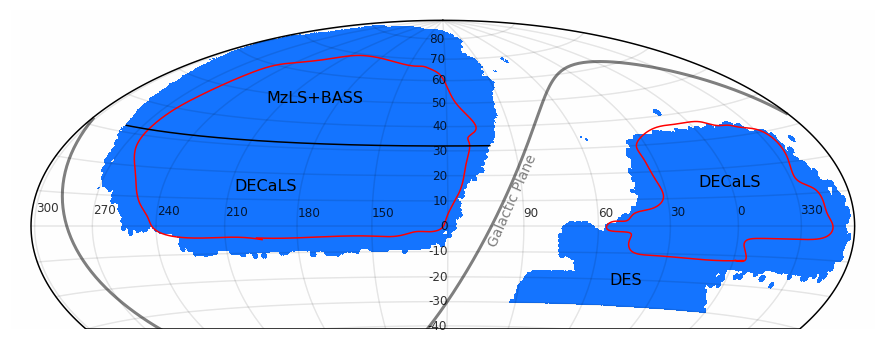

In [215]:
plt.figure(figsize=(12,6))
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.imshow(rgb, origin='lower')

dec_gridlines = list(range(-80, 90, 10))
dec_gridlines_ras = np.arange(rotate-180, rotate+181)
ra_gridlines = range(0, 360, 30)
ra_gridlines_decs = np.arange(-80, 91, 1.)
drawkwargs = dict()
drawkwargs.update(
    ra_gridlines_decs=ra_gridlines_decs,
    dec_gridlines_ras=dec_gridlines_ras,
)
drawkwargs.update(ra_gridlines=ra_gridlines, dec_gridlines=dec_gridlines)
draw_grid(wcs, **drawkwargs)

rr = rotate-180.
dd = np.arange(-30,91)
ok,xx,yy = wcs.radec2pixelxy(rr, dd)
plt.plot(xx, yy, 'k-')
x0,y0 = xx[0],yy[0]
rr = rotate+180.
dd = np.arange(-30,91)
ok,xx,yy = wcs.radec2pixelxy(rr, dd)
x1,y1 = xx[0],yy[0]
plt.plot(xx, yy, 'k-')
plt.plot([x0,x1], [y0,y1], 'k-')

labelra = 120
for dec in np.arange(-40, 90, 10):
    ok,x,y = wcs.radec2pixelxy(labelra, dec)
    plt.text(x, y, '%i' % dec, ha='right', va='center', alpha=0.8, fontsize=12)

labeldec = 5
for ra in np.arange(0, 360, 30):
    if ra == 120:
        continue
    ok,x,y = wcs.radec2pixelxy(ra, labeldec)
    plt.text(x, y, '%i' % ra, ha='left', va='center', alpha=0.8, fontsize=12)
    
plt.xticks([]); plt.yticks([])

for fx,fy in sdss_boundaries:
    tt = np.linspace(0, 1, 1000)
    plt.plot(fx(tt), fy(tt), 'r-')

from astrometry.util.starutil_numpy import *
ll = np.arange(71, 360+70)
bb = np.zeros_like(ll)
rr,dd = lbtoradec(ll, bb)
ok,x,y = wcs.radec2pixelxy(rr, dd)
plt.plot(x, y, 'k-', alpha=0.5, lw=3)

rr,dd = lbtoradec(200., -3.)
ok,x,y = wcs.radec2pixelxy(rr, dd)
plt.text(x, y, 'Galactic Plane', rotation=66, fontsize=14, color='0.5', ha='center', va='center')

rr = np.arange(101,280)
dd = np.zeros_like(rr) + 32
ok,x,y = wcs.radec2pixelxy(rr,dd)
plt.plot(x, y, 'k-')

for r,d,txt in [(195, 50, 'MzLS+BASS'),
               (195, 15, 'DECaLS'),
               (0, 15, 'DECaLS'),
                (45, -20, 'DES')]:
    ok,x,y = wcs.radec2pixelxy(r, d)
    plt.text(x, y, txt, color='k', fontsize=16, ha='center', va='center')

plt.axis([100, 3500, int(y0), 1750])
gca = plt.gca()
gca.set_frame_on(False)
plt.savefig('coverage.png')